# MNIST Practice

## Goals
* Use PyTorch to do a somewhat basic classifier

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
num_labels = 10 # for for each digit

num_epochs = 100

In [3]:
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Getting the data


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)) # map data set from 0-255 to -0.5-0.5
])

os.makedirs('data_train',exist_ok=True)

# Need to verify that the training and other datasets are non-overlapping

# torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
mnist_set = torchvision.datasets.MNIST(root="data_train",train=True,download=True,transform=transform)

os.makedirs('data_test',exist_ok=True)
mnist_set_test = torchvision.datasets.MNIST(root="data_test",train=False,download=True,transform=transform)



100%|██████████| 9912422/9912422 [00:00<00:00, 101884272.34it/s]


Extracting data_train/MNIST/raw/train-images-idx3-ubyte.gz to data_train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62216586.45it/s]


Extracting data_train/MNIST/raw/train-labels-idx1-ubyte.gz to data_train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24341787.85it/s]


Extracting data_train/MNIST/raw/t10k-images-idx3-ubyte.gz to data_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16963961.50it/s]


Extracting data_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 93363105.52it/s]


Extracting data_test/MNIST/raw/train-images-idx3-ubyte.gz to data_test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 54639464.96it/s]


Extracting data_test/MNIST/raw/train-labels-idx1-ubyte.gz to data_test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25410843.49it/s]


Extracting data_test/MNIST/raw/t10k-images-idx3-ubyte.gz to data_test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]

Extracting data_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_test/MNIST/raw



In [5]:
# Data Loader
batch_size = 32
mnist_loader = DataLoader(dataset=mnist_set,batch_size=batch_size,shuffle=True)

tensor([6, 3, 7, 6, 9, 0, 4, 8, 4, 3, 3, 0, 1, 0, 3, 0, 0, 4, 3, 6, 6, 3, 3, 5,
        3, 4, 1, 5, 6, 8, 7, 1])
torch.Size([32, 1, 28, 28])
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9843,  0.9765,
         0.9765, -0.1529, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.6706,
         0.7333,  0.9765,  0.9843,  0.9765,  0.9765,  0.9765,  0.9843,  0.9765,
         0.8510, -0.5137, -1.0000, -1.0000])
28


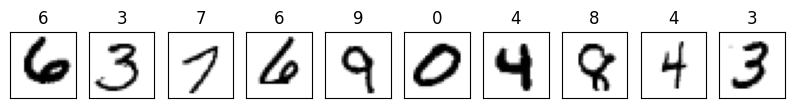

In [6]:
train_features, train_labels = next(iter(mnist_loader))
print(train_labels)
print(train_features.shape)
print(train_features[0][0][13])

image_size = train_features.shape[2]
print(image_size)

num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    ax[i].imshow(train_features[i].squeeze(),cmap='binary')
    ax[i].set_title(train_labels[i].item())
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [7]:
#count = 0
#for batch in mnist_loader:
#    images, labels = batch
#    break


## Planning Notes
* Should use a neural network with 10 output nodes, linear output. This gets plugged into the the logistic function, giving the probability for each.
* What about normalizing the output so that each output, after applying the logistic function

In [8]:
# useful for one-hot encoding the truth variables
# identity_tensor = torch.eye(num_labels)


# from this: https://neuralthreads.medium.com/categorical-cross-entropy-loss-the-most-important-loss-function-d3792151d05b
# it seems like there is potential for optimization by explicitly giving the analytical 

debug_cat = False
# mimicking the from_logits variable from TF
#
def CatCrossEntropy(result,truth,from_logits=True):
    """
     Args:
        result (tensor): Results from the model, to be compared to the truth (batch_dim,num_labels)
        truth (tensor): Target of the model (batch_dim,)
        from_logits (bool): If true, assume linear input. If false, assume logistic function already applied
 
    """
    if (debug_cat):
        print(result)
        print(truth)
    batch_size = result.shape[0]
    total = 0
    if from_logits:
        softmaxed_input = torch.softmax(result,dim=-1) # apply along the last dimension
    else:
        softmaxed_input = result
    if debug_cat:
        print("Sum of softmax")
        print(torch.sum(softmaxed_input,dim=1))
        
    #log_truth = torch.log(truth)
    # encode truth as one-hot
    truth_one_hot = torch.zeros((batch_size,num_labels)).to(device)
    # would it be faster to have one tensor that is always on the device?
    for i in range(batch_size):
        truth_val = int(truth[i])
        truth_one_hot[i][truth_val] = 1.0
    if debug_cat:
        print("Tensors to multiply")
        print(softmaxed_input)
        print(truth_one_hot)
    
    # sum up -truth_one_hot * log(softmax_input)
    total = - torch.sum(truth_one_hot*torch.log(softmaxed_input),dim=[1])
    # sum up over batch
    total = torch.sum(total,dim=[0])
    
    return total


test_tensor1 = torch.tensor([[0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,],
                             [0.,0.,0.,0.,0.,5.,0.,0.,0.,0.5,],
                             [0.5,0.5,0.5,0.5,0.5,5.,0.5,0.5,0.5,0.5,]],requires_grad=True) # mimicking a linear output
test_tensor2 = torch.tensor([5,5,5]) # mimicking a truth label
#load to device
test_tensor1 = test_tensor1.to(device)
test_tensor2 = test_tensor2.to(device)

test_entropy = CatCrossEntropy(test_tensor1,test_tensor2)
print(type(test_entropy))
print(test_entropy)

<class 'torch.Tensor'>
tensor(4.6169, grad_fn=<SumBackward1>)


## Buiding the Model

In [9]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12,(3,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12,24,(3,3))
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24*5*5,25), # don't know if this size is right
            nn.ReLU(),
            nn.Linear(25,20),
            nn.ReLU(),
            nn.Linear(20,10),
        )
    def forward(self,x):
        #x = x.squeeze() 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.linear_relu_stack(x)
        return x
    
    

In [10]:
torch.manual_seed(0)
model = MyNeuralNetwork().to(device)
print(model)

MyNeuralNetwork(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=600, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [11]:
from torch.optim.lr_scheduler import ExponentialLR

In [12]:
#criterion = nn.MSELoss()
criterion = CatCrossEntropy
optimizer = optim.SGD(model.parameters(), lr=0.005)
scheduler = ExponentialLR(optimizer, gamma=0.995)
num_epochs = 10

In [13]:
print_steps = 5
print_steps_batch = 100

# note that this is currently saved at the batch level, not the epoch
loss_train_list = []
lr_list = []
for epoch in range(num_epochs):
    batch_count = 0
    for images,labels in mnist_loader:
        images = images.to(device)
        labels = labels.to(device)
        #images, labels = batch
        model.train()
        output = model(images)
        
        loss = criterion(output,labels).to(device)
        loss_train_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lr_list.append(scheduler.get_last_lr())
        
        if (batch_count + 1) % (print_steps_batch) == 0:
            print(f"Epoch {epoch+1}, batch {batch_count + 1}, Loss: {loss.item():.4f}")
        
        batch_count += 1
    if (epoch + 1) % print_steps == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        
    scheduler.step() # try stepping the schedulear at the epoch level
        


Epoch 1, batch 100, Loss: 27.1165
Epoch 1, batch 200, Loss: 5.8114
Epoch 1, batch 300, Loss: 5.5192
Epoch 1, batch 400, Loss: 5.2346
Epoch 1, batch 500, Loss: 0.4600
Epoch 1, batch 600, Loss: 2.0597
Epoch 1, batch 700, Loss: 2.4303
Epoch 1, batch 800, Loss: 3.8785
Epoch 1, batch 900, Loss: 1.3938
Epoch 1, batch 1000, Loss: 3.3711
Epoch 1, batch 1100, Loss: 0.1528
Epoch 1, batch 1200, Loss: 2.1286
Epoch 1, batch 1300, Loss: 7.3640
Epoch 1, batch 1400, Loss: 1.8613
Epoch 1, batch 1500, Loss: 0.7401
Epoch 1, batch 1600, Loss: 6.6476
Epoch 1, batch 1700, Loss: 1.9807
Epoch 1, batch 1800, Loss: 0.1720
Epoch 2, batch 100, Loss: 1.8024
Epoch 2, batch 200, Loss: 3.2964
Epoch 2, batch 300, Loss: 0.4298
Epoch 2, batch 400, Loss: 5.1729
Epoch 2, batch 500, Loss: 2.7683
Epoch 2, batch 600, Loss: 0.2368
Epoch 2, batch 700, Loss: 0.4146
Epoch 2, batch 800, Loss: 0.0480
Epoch 2, batch 900, Loss: 0.0678
Epoch 2, batch 1000, Loss: 0.6671
Epoch 2, batch 1100, Loss: 3.5518
Epoch 2, batch 1200, Loss: 1.45

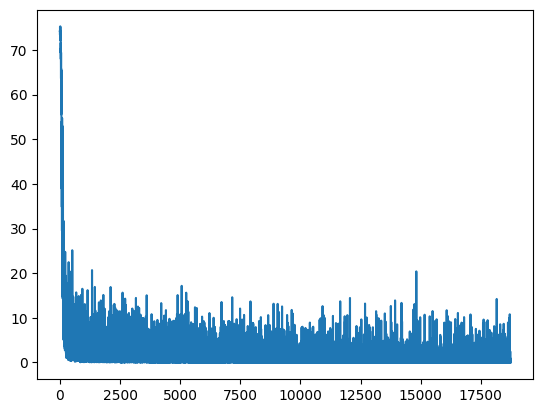

In [14]:
plt.plot(loss_train_list)

In [15]:
# run a test with the training data
train_features_local, train_labels_local = next(iter(mnist_loader))
train_features = train_features_local.to(device)
train_labels   = train_labels_local.to(device)


tensor([3, 5, 0, 8, 0, 2, 9, 3, 5, 7, 4, 1, 8, 0, 4, 9, 6, 7, 1, 2, 8, 1, 3, 6,
        8, 2, 8, 7, 0, 6, 1, 7])
tensor([3, 5, 0, 8, 0, 2, 9, 3, 5, 7, 4, 1, 8, 0, 4, 9, 6, 7, 1, 2, 8, 1, 3, 6,
        8, 2, 8, 7, 0, 6, 1, 7])


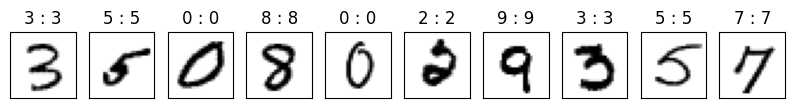

In [16]:
with torch.no_grad():
    model.eval()
    output = model(train_features)
    output = torch.softmax(output,dim=-1)
    output = torch.argmax(output,dim=-1)
    output_local = output.cpu()
    print(output)
    print(train_labels)
    
num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    
    
    ax[i].imshow(train_features_local[i].squeeze(),cmap='binary')
    ax[i].set_title(f"{train_labels_local[i].item()} : {output_local[i].item()}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [17]:
# Test

# Data Loader
batch_size = 32
mnist_loader_test = DataLoader(dataset=mnist_set_test,batch_size=batch_size,shuffle=True)



In [18]:
# run a test with the test loader
# run a test with the training data
train_features_local, train_labels_local = next(iter(mnist_loader_test))
train_features = train_features_local.to(device)
train_labels   = train_labels_local.to(device)


tensor([7, 7, 3, 8, 9, 3, 0, 4, 4, 5, 4, 1, 8, 3, 9, 9, 0, 7, 9, 5, 2, 8, 0, 9,
        9, 5, 5, 7, 8, 1, 9, 8])
tensor([7, 7, 3, 8, 9, 3, 0, 4, 4, 5, 4, 1, 8, 3, 9, 9, 0, 7, 9, 5, 2, 8, 0, 9,
        9, 5, 5, 7, 8, 7, 9, 8])


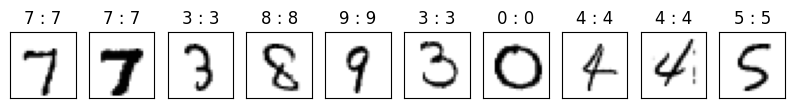

In [19]:
with torch.no_grad():
    model.eval()
    output = model(train_features)
    output = torch.softmax(output,dim=-1)
    output = torch.argmax(output,dim=-1)
    output_local = output.cpu()
    print(output)
    print(train_labels)
    
num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    
    
    ax[i].imshow(train_features_local[i].squeeze(),cmap='binary')
    ax[i].set_title(f"{train_labels_local[i].item()} : {output_local[i].item()}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Evaluation


In [20]:
total_count = 0
correct_count = 0
# for debugging:
incorrect_count = 0

#batch_size

#temp_cutoff = 300

for images_local,labels_local in mnist_loader_test:
    #if total_count > temp_cutoff:
    #    break
    with torch.no_grad():
        images = images_local.to(device)
        labels = labels_local.to(device)
        #images, labels = batch
        model.eval()
        output = model(images)
        output = torch.softmax(output,dim=-1)
        output = torch.argmax(output,dim=-1)
        output_local = output.cpu()
        #print(output)
        #print(labels_local)
        
        total_count += output_local.shape[0]
        # probably a more efficient way to do this
        
        comparison = torch.eq(output,labels)
        #print(comparison)
        comparison_sum = torch.sum(comparison)
        #print(comparison_sum)
        correct_count += comparison_sum.item()
        incorrect_count += (labels.shape[0] - comparison_sum.item())
        
        #for i in output_local.shape[0]:
            #if torch.equal(output_local[i],
print(f"Total: {total_count}, Correct: {correct_count}, Incorrect: {incorrect_count}")
print(f"Accuracy: {1.0*correct_count / total_count}")
print(f"Error rate: {1.0*incorrect_count / total_count}")


Total: 10000, Correct: 9892, Incorrect: 108
Accuracy: 0.9892
Error rate: 0.0108
